# Baseline Model in python

In [431]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.special import logit
from sklearn.metrics import accuracy_score, log_loss as cross_entropy_score

In [432]:
from numpy.random import default_rng
rng = default_rng(seed=1234321)

In [433]:
from masterthesis.data import load_acinar, data_dir
# load the python AnnData object
acinar_ann = load_acinar()

In [434]:
print("Dataset shape", acinar_ann.X.shape)
print("First gene:", acinar_ann.X[:,0].shape)

Dataset shape (411, 23368)
First gene: (411,)


In [435]:
# Access Gene Names
acinar_ann.var_names

Index(['1/2-SBSRNA4', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2LD1', 'A2M', 'A2ML1',
       'A2MP1', 'A4GALT', 'A4GNT',
       ...
       'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11A', 'ZYG11B', 'ZYX', 'ZZEF1',
       'ZZZ3', 'tAKR'],
      dtype='object', length=23368)

In [436]:
# select one gene
acinar_ann[:, acinar_ann.var_names.str.match("A1CF")]

View of AnnData object with n_obs × n_vars = 411 × 1
    obs: 'wellKey', 'geo_accession', 'donor_age', 'gender', 'inferred_cell_type'
    var: 'primerid'
    uns: 'X_name'
    layers: 'counts', 'tpm'

### R Gene selection and Test Split

In [437]:
# sampling in R with seed 1234
test_idx = [284, 336, 406, 101, 111, 393, 133, 400, 388, 98, 103, 214, 90, 326, 79, 372, 270, 382, 184, 62, 4, 403, 149, 40, 212, 195, 93, 122, 66, 175, 379, 304, 108, 131, 343, 41, 115, 228, 328, 298, 299]
train_idx = list(set(range(acinar_ann.X.shape[0])) - set(test_idx))

In [438]:
# selected Genes after preprocessing in R
sel_genes = ["REG3A", "AMY2A", "MT2A", "OLFM4",
             "SYCN", "CELA2B", "FGL1", "AMY2B",
             "MT1G", "TM4SF1", "CELA2A", "PDK4", 
             "TACSTD2", "CD44", "PNLIPRP2", "ALB", 
             "ERP27", "LDHA", "REG3G", "CTRL", "CLPS",
             "FOS", "HSPA8", "SERPINA3", "CELA3B", "CRP" ]

In [439]:
from sklearn.model_selection import train_test_split

y = np.array([int(x) for x in acinar_ann.obs.donor_age])
k = len(np.unique(y))
X_train, X_test, y_train, y_test = train_test_split(acinar_ann[:,sel_genes].X, y, 
                                                    test_size=0.1, 
                                                    stratify=y,
                                                    random_state=1234)

In [440]:
# old approach based on the indexes from R
#y_train = y[train_idx]
#y_test = y[test_idx]

#X_train = acinar_ann[test_idx, sel_genes].X
#X_test = acinar_ann[train_idx, sel_genes].X

In [441]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [442]:
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)
print("Train X:", X_train.shape)
print("Train y:", y_train.shape)

Test X: (42, 26)
Test y: (42,)
Train X: (369, 26)
Train y: (369,)


## Model 1: mord

**Result: It was not possible to achieve the necessary sparsity with this model. Only L2 regularization is required. The thresholds seem not entirely plausible**

[Reference 1](https://medium.datadriveninvestor.com/logistic-regression-simple-multinomial-and-ordinal-b2bc886bb974) [Reference 2](https://pythonhosted.org/mord/)

In [443]:
from mord import LogisticAT, LogisticIT

In [444]:
# Transform y into a series of subsequent labels [0,1,2 ...]
transf = dict(zip(np.unique(y),
                  np.arange(0, len(np.unique(y)))))
                        
y_train_trans = np.array([transf[e] for e in y_train])
y_test_trans = np.array([transf[e] for e in y_test])

# reordering, such that yi < yi+1
train_reorder = np.argsort(y_train_trans)
test_reorder = np.argsort(y_test_trans)

In [445]:
# all-threshold fit
regressor = LogisticAT(verbose=0, alpha=0.1)
regressor.fit(X_train, y_train_trans)
regressor.score(X_test, y_test_trans)

-1.2619047619047619

In [446]:
# immediate-threshold fit
regressor = LogisticIT(verbose=0, alpha=0, )
regressor.fit(X_train[train_reorder], y_train_trans[train_reorder])
regressor.score(X_test[test_reorder], y_test_trans[test_reorder])

0.38095238095238093

In [447]:
regressor.coef_

array([ 0.44116335,  0.34111261,  0.46324913,  0.03337747,  0.49242948,
       -0.38978002,  0.1064584 ,  0.30709031, -0.01977034,  0.15211454,
       -0.31710565,  0.13906532, -0.08686401,  0.48321721, -0.11721669,
        0.24753368, -0.30225062,  0.07715455, -0.21801211, -0.37108485,
       -1.02519282, -0.2038906 , -0.1342585 ,  0.38484625,  0.97416737,
       -0.01220314])

In [448]:
regressor.theta_

array([-2.3533254 ,  0.48773183,  0.48773183,  0.65012671,  0.65012671,
        1.98465256,  1.98465256])

## Model 2: Ordered Multinomial Regression (statsmodels) 

**Result: Introducing sparsity, or even using any regularizer seems to not be supported, or at least I didn't find a way.**

In [449]:
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [450]:
mod_prob = OrderedModel(y_train,
                        X_train,
                        distr='logit')

res_prob = mod_prob.fit(method='bfgs')
res_prob.summary().tables[0]

Optimization terminated successfully.
         Current function value: 1.342428
         Iterations: 63
         Function evaluations: 64
         Gradient evaluations: 64


Dep. Variable:,y,Log-Likelihood:,-495.36
Model:,OrderedModel,AIC:,1057.
Method:,Maximum Likelihood,BIC:,1186.
Date:,"Sat, 01 Apr 2023",,
Time:,22:25:33,,
No. Observations:,369,,
Df Residuals:,336,,
Df Model:,33,,


In [451]:
res_prob.params

array([ 7.59097438e-01,  3.60263399e-01,  7.59210461e-01,  8.26093777e-02,
        7.36748059e-01, -7.79475940e-01,  1.57168023e-01,  5.29276959e-01,
       -2.81775746e-03,  2.37234125e-01, -2.63643948e-01,  3.54884548e-01,
       -3.89196433e-01,  7.37195947e-01, -3.59803571e-01,  3.94366062e-01,
       -5.52783903e-01,  7.23712621e-02, -3.52474947e-01, -6.70490332e-01,
       -1.20057629e+00, -2.86066005e-01, -1.00226074e-01,  8.30967443e-01,
        1.30308019e+00, -9.53358801e-03, -3.59336783e+00,  1.11975597e+00,
       -3.74626777e-01,  3.04805204e-01, -1.70403320e+00,  6.37809158e-01,
       -2.64526992e-01])

In [452]:
predictions = res_prob.model.predict(res_prob.params, exog=X_test)
print("Predictions:", predictions.argmax(1))
print("Ground Truth:", y_test_trans)
print("Cross Entropy:", cross_entropy_score(y_test, predictions, labels=np.unique(y)))
print("Accuracy:", accuracy_score(predictions.argmax(1), y_test_trans))

Predictions: [3 1 5 3 0 7 1 3 1 1 1 1 0 5 5 1 3 1 3 5 7 1 5 3 3 3 1 0 5 5 1 3 0 1 5 1 0
 5 0 5 1 5]
Ground Truth: [5 2 3 1 4 7 5 2 1 6 3 3 0 5 7 1 1 5 5 6 7 1 3 1 1 7 1 0 5 3 1 2 0 2 3 5 0
 5 0 1 1 3]
Cross Entropy: 1.6736239380459572
Accuracy: 0.38095238095238093


## Model 3: Multinomial Regression (sklearn)

**Results:** 
- Introduction of sparsity worked well with the l1 penalty
- Prediction results were on par with the other methods
- However, since this is solved as a multinomial regression problem, one set of parameters is fit for each prediction class. This introduces a new problem for selection of parameters: The weights have to be aggregated, which has eliminated the sparsity with the attempted approaches.

In [453]:
from sklearn.linear_model import LogisticRegression

sk_model = LogisticRegression(penalty="l1",
                              multi_class="multinomial", # "auto", "ovr", "multinomial"
                              solver="saga",
                              random_state=12345)
sk_model.fit(X_train, y_train)

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(multi_class='multinomial', penalty='l1', random_state=12345,
                   solver='saga')

In [454]:
print("Model coefficients shape:", sk_model.coef_.shape)
print("Train score:", sk_model.score(X_train, y_train))
print("Test score:", sk_model.score(X_test, y_test))

Model coefficients shape: (8, 26)
Train score: 0.9512195121951219
Test score: 0.8333333333333334


#### Aggregation of Weights from multinomial model


In [455]:
# defines a threshold below which a gene is not considered significant
# this is arbitrary, there is no way of defining this
sparsity_threshold = 0.0001

skl_mm_added = np.add.reduce(sk_model.coef_, axis=0)
print("Added weights from Muli-Class model")
print("sparsity:", sum(np.abs(skl_mm_added) < sparsity_threshold))

skl_mm_mean = skl_mm_added / sk_model.coef_.shape[1]
print("Average weights from Muli-Class model")
print("sparsity:", sum(np.abs(skl_mm_mean) < sparsity_threshold))

Added weights from Muli-Class model
sparsity: 0
Average weights from Muli-Class model
sparsity: 0


## Models 4-6: Binary LogisticRegression (sklearn)

### Convert the data

- The labels are converted to binary, such that the threshold from 0-1 corresponds from changing from label $l_i$ to $l_{i+1}$. $k$ copies of the label vector are concatenated such that for every vector $j$ the labels  $l_i$ with $i<j$ are converted to 0 and the labels $i\ge j$ are converted to 1.
- The count matrix is extended with copies of itself, to fit the converted label vector FOR NOW. For big problems, it could suffice to have just one label vector and perform and iterative training.
- To train the thresholds, $k$ columns are added to the count matrix and initialized to zero. Each column column represents the threshold for a label $l_i$ and is set to 1, exactly  where that label $l_1$ occurs.

In [456]:
def to_bin_y(y_orig):
    y_classes = np.unique(y_orig)
    k = len(y_classes)

    y_bin = []
    for ki in range(1,k):
        thresh = y_classes[ki]
        y_bin += [int(x>=thresh) for x in y_orig]

    y_bin = np.array(y_bin)
    
    return y_bin 

In [457]:
def to_bin_X(X_orig, k):

    # X training matrix
    X_bin = np.concatenate([X_orig.copy()] * (k-1))
    # Add thresholds
    num_el = X_orig.shape[0] * (k-1)

    for ki in range(k-1):
        temp = np.repeat(0, num_el).reshape(X_orig.shape[0], (k-1))
        temp[:,ki] = 1
        if ki > 0:
            thresholds = np.concatenate([thresholds, temp])
        else:
            thresholds = temp

    X_bin = np.concatenate([X_bin, thresholds], axis=1)

    return X_bin

In [458]:
y_train_bin = to_bin_y(y_train)
print("y_train:", len(y_train_bin))

y_test_bin = to_bin_y(y_test)
print("y_test:", len(y_test_bin))

y_train: 2583
y_test: 294


In [459]:
X_train_bin = to_bin_X(X_train, k=np.unique(y).size)
print("X_train_bin:", X_train_bin.shape)

X_test_bin = to_bin_X(X_test, k=np.unique(y).size)
print("X_test_bin:", X_test_bin.shape)

X_train_bin: (2583, 33)
X_test_bin: (294, 33)


### Model 4: LogisticRegression (sklearn)

In [460]:
from sklearn.linear_model import LogisticRegression

sk_binlogreg_model = LogisticRegression(penalty="l1", 
                                  fit_intercept=False,
                                  max_iter=10000,
                                  solver="liblinear",
                                  random_state=1234,
                                  C=0.01  # Inverse of regularization strength -> controls sparsity in our case!
                                 )

sk_binlogreg_model.fit(X_train_bin, y_train_bin)

LogisticRegression(C=0.01, fit_intercept=False, max_iter=10000, penalty='l1',
                   random_state=1234, solver='liblinear')

In [461]:
print("Train score:",sk_binlogreg_model.score(X_train_bin, y_train_bin))
print("Test score:",sk_binlogreg_model.score(X_test_bin, y_test_bin))

Train score: 0.7770034843205574
Test score: 0.7653061224489796


In [462]:
sk_binlogreg_model.coef_

array([[ 0.27050863,  0.        ,  0.        ,  0.        ,  0.        ,
        -0.01287085,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.07369993,  0.        ,  0.10880254,  0.        ,
         0.        , -0.13150305,  0.        , -0.10582882, -0.0518537 ,
         0.        ,  0.        ,  0.        ,  0.35514256,  0.        ,
         0.        ,  0.4170856 ,  0.        ,  0.        ,  0.        ,
         0.        , -0.44601961, -0.64557786]])

## Binary Logistic Regression with GLMnet

In [463]:
from glmnet import LogitNet

# Note: Alpha is the regularization mixing parameter: alpha=1 -> L1, alpha=0 -> L2, 0<alpha<1 -> elastic net 
glmnet_model = LogitNet(alpha=1,
                        fit_intercept=False,
                        standardize=False, # already standardized
                        random_state=1234,
                        max_iter=10000)
glmnet_model.fit(X_train_bin, y_train_bin)

LogitNet(fit_intercept=False, max_iter=10000, random_state=1234,
         standardize=False)

In [464]:
print("Train score: ", glmnet_model.score(X_train_bin, y_train_bin))
print("Test score: ", glmnet_model.score(X_test_bin, y_test_bin))

Train score:  0.8614014711575687
Test score:  0.7857142857142857


In [465]:
glmnet_model.coef_

array([[ 0.47077975,  0.        ,  0.37275445,  0.        ,  0.        ,
        -0.2718176 ,  0.01834662,  0.27956828,  0.        ,  0.00906079,
         0.        ,  0.22041753, -0.1378634 ,  0.18726233, -0.08640451,
         0.08268969, -0.26427331,  0.        , -0.28873376, -0.24587408,
         0.        , -0.07656282, -0.02134246,  0.59662556,  0.05288458,
         0.        ,  1.71402649,  0.10353958,  0.        , -0.48783945,
        -0.62012817, -1.75287372, -2.09708938]])

## SGD with mini Batches

To reduce the memory load, this introduces a sampling method with an iterative training paradigm

ToDo: 

    - Construct matrix on the fly
    - Check convergence / early stopping
    

In [564]:
from sklearn.linear_model import SGDClassifier

sgd_model = SGDClassifier(loss="log_loss",
                          penalty="l1",
                          alpha=0.01,  # = lambda in paper!! Very important to tune for the desired sparsity!
                          fit_intercept=False,
                          n_jobs=1)

cur_iter = 0
max_iter = 10
n_batches = 2

while cur_iter < max_iter:
    if (cur_iter > 0 and cur_iter % 2 == 0):
        print("Iter: ", cur_iter, "Train score: ", sgd_model.score(X_batch, y_batch))
    
    cur_iter += 1
    
    # fit from samples of the big matrix
    # TODO: Sampling from the big matrix directly is just for PoP,
    # and eliminates the purpose. Only the binarized y-vector should
    # be created and the indexes taken from the log count matrix.
    sampled_indices = np.random.randint(X_train_bin.shape[0], size=X_train_bin.shape[0])

    start = 0
    for i in range(1, n_batches+1):
        end = (i * X_train_bin.shape[0] // n_batches)
        idx = sampled_indices[start:end]
        X_batch = X_train_bin[idx,:]
        y_batch = y_train_bin[idx]
        start = end
        sgd_model.partial_fit(X_batch, y_batch, classes=np.unique(y_batch))

Iter:  2 Train score:  0.8660990712074303
Iter:  4 Train score:  0.8359133126934984
Iter:  6 Train score:  0.8831269349845201
Iter:  8 Train score:  0.8614551083591331


In [467]:
print("Train score:", sgd_model.score(X_train_bin, y_train_bin))
print("Test score:", sgd_model.score(X_test_bin, y_test_bin))

Train score: 0.86488579171506
Test score: 0.7857142857142857


In [468]:
sgd_model.coef_

array([[ 4.79259099e-01,  1.78394105e-03,  3.85248633e-01,
         9.87494187e-04,  0.00000000e+00, -3.02257698e-01,
         1.59380624e-02,  2.96531613e-01,  0.00000000e+00,
         1.84085867e-02,  0.00000000e+00,  2.26915489e-01,
        -1.56621802e-01,  2.12078838e-01, -1.01206554e-01,
         9.48899720e-02, -2.80363791e-01, -4.67114562e-04,
        -2.99984387e-01, -2.73172296e-01, -9.63800959e-04,
        -9.11617205e-02, -3.02527998e-02,  6.03849275e-01,
         9.79003020e-02,  0.00000000e+00,  1.80003263e+00,
         1.46916906e-01,  0.00000000e+00, -5.41030177e-01,
        -6.76037844e-01, -1.83828201e+00, -2.19546495e+00]])

# Compare Parameters

- To compare parameters we first fincd the best regularization strength
    * The best regularization has the highest score across 5-fold CV
    * To increase sparsity, we choose the parameter with highest regularization, that lies within 1 standard error of the optimum
- Then we do N fits with different seeds and collect the parameter values. 
- Finally we compare the distributions of the collected parameter values visually and wrt KL-divergence

The models to investigate:  sklearn LinRegressor, GLMnet Mmodel, SGD LinRegressor, and Psupertime


In [470]:
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV

n_folds = 5
kf = StratifiedKFold(n_splits=n_folds)

# elongate the origial non-binarized y-train data
# to enable stratification
y_train_elong = np.repeat(y_train, k-1)

cv_splits = kf.split(X_train_bin, y_train_elong)

In [471]:
from sklearn.metrics import accuracy_score, log_loss, make_scorer

scorers = {
    "accuracy": accuracy_score,
    "cross-entropy": log_loss
}

In [472]:
def dof(params):
    return np.count_nonzero(params != 0)

In [473]:
def cv_res_to_df(cv_results, scorers):
    df = pd.DataFrame.from_dict(cv_results, orient="index").stack().to_frame()
    df = pd.DataFrame(df[0].values.tolist(), index=df.index)
    df.columns = ["L=%s" % x for x in reg_params]

    for scorer in scorers.keys():
        df.loc[("mean", scorer), :] = df.xs(scorer, level=1).mean(axis=0)
    df.loc[("mean", "dof"), :] = df.xs("dof",level=1).mean(axis=0)
    
    return df.T
    

## SKLearn linregressor:


In [474]:
# GRIDSEARCH:
# ------------

#scorers = {
#    "accuracy": make_scorer(accuracy_score),
#    "cross-entropy-loss": make_scorer(log_loss)
#}
#params = {"C": [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005, 0.00001]}
#sk_binlogreg_model = LogisticRegression(penalty="l1", 
#                                  fit_intercept=False,
#                                  max_iter=10000,
#                                  solver="liblinear",
#                                  random_state=1234)
#sk_binlogreg_cv = GridSearchCV(sk_binlogreg_model,
#                               param_grid=params,
#                               refit=False,
#                               cv=kf.split(X_train_bin, y_train_elong),
#                               scoring=scorers)
#sk_binlogreg_cv.cv_results_

# Problem: Does not save parameters of intermediate models: Tracking of sparsity not possible
# Let's do it ourselves ..
# But, still interesting for the final package!

In [515]:
#reg_params = [1, 0.75, 0.5, 0.25, 0.1, 0.075, 0.05, 0.025, 0.01, 0.005, 0.001, 0.0005]
sk_reg_params = np.concatenate((np.linspace(1,10,10)[::-1], np.logspace(1, 15, 20, base=0.5)))
cv_results = dict()

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for c in sk_reg_params:
        model = LogisticRegression(penalty="l1",
                                   C=c,
                                   fit_intercept=False,
                                   max_iter=10000,
                                   solver="liblinear",
                                   random_state=1234);
        
        model.fit(X_train_bin[cv_train_idx,] , y_train_bin[cv_train_idx])
        
        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)
        
        cv_results[s]["dof"].append(dof(model.coef_))


split_0
split_1
split_2
split_3
split_4


In [516]:
sk_linreg_res = cv_res_to_df(cv_results, scorers)
sk_linreg_res

split_0                         split_1            \
                             dof  accuracy cross-entropy     dof  accuracy   
L=10.0                      33.0  0.839458      5.786505    33.0  0.765957   
L=9.0                       33.0  0.839458      5.786505    33.0  0.765957   
L=8.0                       33.0  0.839458      5.786505    33.0  0.765957   
L=7.0                       33.0  0.837524      5.856222    33.0  0.765957   
L=6.0                       33.0  0.837524      5.856222    33.0  0.765957   
L=5.0                       33.0  0.837524      5.856222    33.0  0.765957   
L=4.0                       33.0  0.837524      5.856222    33.0  0.767892   
L=3.0                       33.0  0.839458      5.786505    32.0  0.767892   
L=2.0                       33.0  0.831721      6.065373    32.0  0.769826   
L=1.0                       32.0  0.822050      6.413958    31.0  0.777563   
L=0.5                       31.0  0.764023      8.505466    31.0  0.785300   
L=0.3000256798945257        31.0  0.684720     11.363860    30.0  0.791103   
L=0.18003081719234487       30.0  0.644101     12.827915    29.0  0.791103   
L=0.10802773666020071       26.0  0.653772     12.479331    29.0  0.806576   
L=0.064822190277887         24.0  0.663443     12.130746    27.0  0.829787   
L=0.038896643420750734      21.0  0.671180     11.851878    22.0  0.827853   
L=0.023339983775851347      15.0  0.661509     12.200463    17.0  0.833656   
L=0.014005189002153997      11.0  0.657640     12.339897    12.0  0.818182   
L=0.008403832704845177       9.0  0.665377     12.061029     8.0  0.827853   
L=0.005042731241982053       3.0  0.686654     11.294143     2.0  0.785300   
L=0.0030258977388020625      0.0  0.210832     28.444508     0.0  0.452611   
L=0.0018156940527507943      0.0  0.210832     28.444508     0.0  0.452611   
L=0.0010895096853140082      0.0  0.210832     28.444508     0.0  0.452611   
L=0.0006537617681760124      0.0  0.210832     28.444508     0.0  0.452611   
L=0.0003922906379721105      0.0  0.210832     28.444508     0.0  0.452611   
L=0.00023539453074767952     0.0  0.210832     28.444508     0.0  0.452611   
L=0.00014124880826205084     0.0  0.210832     28.444508     0.0  0.452611   
L=8.475653946622664e-05      0.0  0.210832     28.444508     0.0  0.452611   
L=5.085827675772371e-05      0.0  0.210832     28.444508     0.0  0.452611   
L=3.0517578125e-05           0.0  0.210832     28.444508     0.0  0.452611   

                                       split_2                          \
                         cross-entropy     dof  accuracy cross-entropy   
L=10.0                        8.435749    33.0  0.814313      6.692825   
L=9.0                         8.435749    33.0  0.814313      6.692825   
L=8.0                         8.435749    33.0  0.814313      6.692825   
L=7.0                         8.435749    33.0  0.814313      6.692825   
L=6.0                         8.435749    33.0  0.814313      6.692825   
L=5.0                         8.435749    33.0  0.814313      6.692825   
L=4.0                         8.366032    33.0  0.814313      6.692825   
L=3.0                         8.366032    32.0  0.814313      6.692825   
L=2.0                         8.296315    32.0  0.816248      6.623108   
L=1.0                         8.017447    31.0  0.816248      6.623108   
L=0.5                         7.738579    31.0  0.810445      6.832259   
L=0.3000256798945257          7.529429    31.0  0.810445      6.832259   
L=0.18003081719234487         7.529429    29.0  0.800774      7.180844   
L=0.10802773666020071         6.971693    29.0  0.793037      7.459712   
L=0.064822190277887           6.135090    26.0  0.764023      8.505466   
L=0.038896643420750734        6.204807    22.0  0.750484      8.993484   
L=0.023339983775851347        5.995656    17.0  0.721470     10.039238   
L=0.014005189002153997        6.553392    12.0  0.702128     10.736407   
L=0.008403832704845177        6.204807     8.0  

In [478]:
- sk_linreg_res[("mean", "accuracy")].std() + sk_linreg_res[("mean", "accuracy")].max()

0.6994166719727218

## glmnet model

In [517]:
from glmnet import LogitNet

glmnet_reg_params = np.concatenate((np.linspace(1,10,10)[::-1], np.logspace(1, 15, 20, base=0.5)))
cv_results = dict()

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for l in glmnet_reg_params:
        model = LogitNet(alpha=1,
                         lambda_path=[l],
                         fit_intercept=False,
                         standardize=False,
                         random_state=1234,
                         max_iter=10000)

        model.fit(X_train_bin[cv_train_idx,] , y_train_bin[cv_train_idx])

        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)

        cv_results[s]["dof"].append(dof(model.coef_))


split_0


/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

split_1


/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

split_2


/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

split_3


/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

split_4


/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path has a single value, this may be an "
/home/julian/.local/share/virtualenvs/experiments-0Bwu2BGA/lib/python3.10/site-packages/glmnet/util.py:202: RuntimeWarning: lambda_path has a single value, this may be an intercept-only model.
  warnings.warn("lambda_path h

In [518]:
glmnet_cv_res = cv_res_to_df(cv_results, scorers)
glmnet_cv_res

split_0                         split_1            \
                             dof  accuracy cross-entropy     dof  accuracy   
L=10.0                       0.0  0.210832     28.444508     0.0  0.452611   
L=9.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=8.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=7.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=6.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=5.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=4.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=3.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=2.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=1.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=0.5                        0.0  0.210832     28.444508     0.0  0.452611   
L=0.3000256798945257         0.0  0.210832     28.444508     0.0  0.452611   
L=0.18003081719234487        0.0  0.210832     28.444508     0.0  0.452611   
L=0.10802773666020071        2.0  0.694391     11.015275     1.0  0.756286   
L=0.064822190277887          7.0  0.665377     12.061029     7.0  0.837524   
L=0.038896643420750734      11.0  0.649903     12.618765    12.0  0.816248   
L=0.023339983775851347      15.0  0.657640     12.339897    17.0  0.825919   
L=0.014005189002153997      20.0  0.665377     12.061029    20.0  0.837524   
L=0.008403832704845177      23.0  0.669246     11.921595    27.0  0.823985   
L=0.005042731241982053      25.0  0.651838     12.549048    29.0  0.812379   
L=0.0030258977388020625     29.0  0.646035     12.758198    29.0  0.800774   
L=0.0018156940527507943     31.0  0.655706     12.409614    30.0  0.794971   
L=0.0010895096853140082     31.0  0.756286      8.784333    31.0  0.785300   
L=0.0006537617681760124     31.0  0.804642      7.041410    31.0  0.777563   
L=0.0003922906379721105     33.0  0.820116      6.483675    31.0  0.773694   
L=0.00023539453074767952    33.0  0.831721      6.065373    32.0  0.769826   
L=0.00014124880826205084    33.0  0.837524      5.856222    33.0  0.767892   
L=8.475653946622664e-05     33.0  0.837524      5.856222    33.0  0.765957   
L=5.085827675772371e-05     33.0  0.839458      5.786505    33.0  0.765957   
L=3.0517578125e-05          33.0  0.837524      5.856222    33.0  0.765957   

                                       split_2                          \
                         cross-entropy     dof  accuracy cross-entropy   
L=10.0                       19.729892     0.0  0.626692     13.455368   
L=9.0                        19.729892     0.0  0.626692     13.455368   
L=8.0                        19.729892     0.0  0.626692     13.455368   
L=7.0                        19.729892     0.0  0.626692     13.455368   
L=6.0                        19.729892     0.0  0.626692     13.455368   
L=5.0                        19.729892     0.0  0.626692     13.455368   
L=4.0                        19.729892     0.0  0.626692     13.455368   
L=3.0                        19.729892     0.0  0.626692     13.455368   
L=2.0                        19.729892     0.0  0.626692     13.455368   
L=1.0                        19.729892     0.0  0.626692     13.455368   
L=0.5                        19.729892     0.0  0.626692     13.455368   
L=0.3000256798945257         19.729892     0.0  0.626692     13.455368   
L=0.18003081719234487        19.729892     0.0  0.626692     13.455368   
L=0.10802773666020071         8.784333     3.0  0.700193     10.806124   
L=0.064822190277887           5.856222     8.0  0.704062     10.666690   
L=0.038896643420750734        6.623108    11.0  0.704062     10.666690   
L=0.023339983775851347        6.274524    16.0  0.707930     10.527257   
L=0.014005189002153997        5.856222    21.0  0.744681      9.202635   
L=0.008403832704845177        6.344241    26.0  

In [481]:
- glmnet_cv_res[("mean", "accuracy")].std() + glmnet_cv_res[("mean", "accuracy")].max()

0.7050208785492782

## SGD Model

In [519]:
from glmnet import LogitNet

sgd_reg_params = np.concatenate((np.linspace(1,10,10)[::-1], np.logspace(1, 15, 20, base=0.5)))
cv_results = dict()

# fixed model training params
max_iter = 50

for i, (cv_train_idx, cv_test_idx) in enumerate(kf.split(X_train_bin, y_train_elong)):
    
    s = "split_%s" % i
    print(s)

    cv_results[s] = dict()
    cv_results[s]["dof"] = []
    for scorer in scorers.keys():
        cv_results[s][scorer] = []
    
    for a in sgd_reg_params:
        
        model = SGDClassifier(loss="log_loss",
                              penalty="l1",
                              alpha=a,  # = lambda in paper!! Very important to tune for the desired sparsity!
                              fit_intercept=False,
                              n_jobs=1)
        cur_iter = 0

        while cur_iter < max_iter:
            cur_iter += 1

            # fit from samples of the big matrix
            # TODO: Sampling from the big matrix directly is just for PoP,
            # and eliminates the purpose. Only the binarized y-vector should
            # be created and the indexes taken from the log count matrix.
            rng.shuffle(cv_train_idx)
            model.partial_fit(X_train_bin[shuffled_indexes,], y_train_bin[shuffled_indexes], classes=np.unique(y_batch))

        for scorer in scorers.keys():
            predicted = model.predict(X_train_bin[cv_test_idx,])            
            score = scorers[scorer](y_train_bin[cv_test_idx], predicted)
            cv_results[s][scorer].append(score)

        cv_results[s]["dof"].append(dof(model.coef_))


split_0
split_1
split_2
split_3
split_4


In [520]:
sgd_cv_res = cv_res_to_df(cv_results, scorers)
sgd_cv_res

split_0                         split_1            \
                             dof  accuracy cross-entropy     dof  accuracy   
L=10.0                       0.0  0.210832     28.444508     0.0  0.452611   
L=9.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=8.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=7.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=6.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=5.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=4.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=3.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=2.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=1.0                        0.0  0.210832     28.444508     0.0  0.452611   
L=0.5                        0.0  0.210832     28.444508     0.0  0.452611   
L=0.3000256798945257         0.0  0.210832     28.444508     0.0  0.452611   
L=0.18003081719234487        1.0  0.765957      8.435749     1.0  0.705996   
L=0.10802773666020071        3.0  0.723404      9.969521     3.0  0.806576   
L=0.064822190277887          6.0  0.804642      7.041410     6.0  0.831721   
L=0.038896643420750734       8.0  0.893617      3.834431     8.0  0.854932   
L=0.023339983775851347      14.0  0.895551      3.764714    14.0  0.847195   
L=0.014005189002153997      20.0  0.899420      3.625280    20.0  0.856867   
L=0.008403832704845177      21.0  0.891683      3.904148    21.0  0.872340   
L=0.005042731241982053      25.0  0.891683      3.904148    25.0  0.864603   
L=0.0030258977388020625     28.0  0.889749      3.973865    28.0  0.860735   
L=0.0018156940527507943     30.0  0.885880      4.113299    30.0  0.862669   
L=0.0010895096853140082     29.0  0.883946      4.183016    32.0  0.845261   
L=0.0006537617681760124     29.0  0.893617      3.834431    31.0  0.845261   
L=0.0003922906379721105     29.0  0.829787      6.135090    29.0  0.862669   
L=0.00023539453074767952    32.0  0.897485      3.694997    30.0  0.872340   
L=0.00014124880826205084    32.0  0.887814      4.043582    31.0  0.831721   
L=8.475653946622664e-05     32.0  0.893617      3.834431    31.0  0.835590   
L=5.085827675772371e-05     32.0  0.831721      6.065373    32.0  0.765957   
L=3.0517578125e-05          32.0  0.849130      5.437921    31.0  0.791103   

                                       split_2                          \
                         cross-entropy     dof  accuracy cross-entropy   
L=10.0                       19.729892     0.0  0.626692     13.455368   
L=9.0                        19.729892     0.0  0.626692     13.455368   
L=8.0                        19.729892     0.0  0.626692     13.455368   
L=7.0                        19.729892     0.0  0.626692     13.455368   
L=6.0                        19.729892     0.0  0.626692     13.455368   
L=5.0                        19.729892     0.0  0.626692     13.455368   
L=4.0                        19.729892     0.0  0.626692     13.455368   
L=3.0                        19.729892     0.0  0.626692     13.455368   
L=2.0                        19.729892     0.0  0.626692     13.455368   
L=1.0                        19.729892     0.0  0.626692     13.455368   
L=0.5                        19.729892     0.0  0.626692     13.455368   
L=0.3000256798945257         19.729892     0.0  0.626692     13.455368   
L=0.18003081719234487        10.596974     1.0  0.603482     14.291971   
L=0.10802773666020071         6.971693     3.0  0.700193     10.806124   
L=0.064822190277887           6.065373     6.0  0.717602     10.178672   
L=0.038896643420750734        5.228770     8.0  0.748549      9.063201   
L=0.023339983775851347        5.507638    14.0  0.764023      8.505466   
L=0.014005189002153997        5.159053    20.0  0.787234      7.668862   
L=0.008403832704845177        4.601317    21.0  

## Compare Fits 

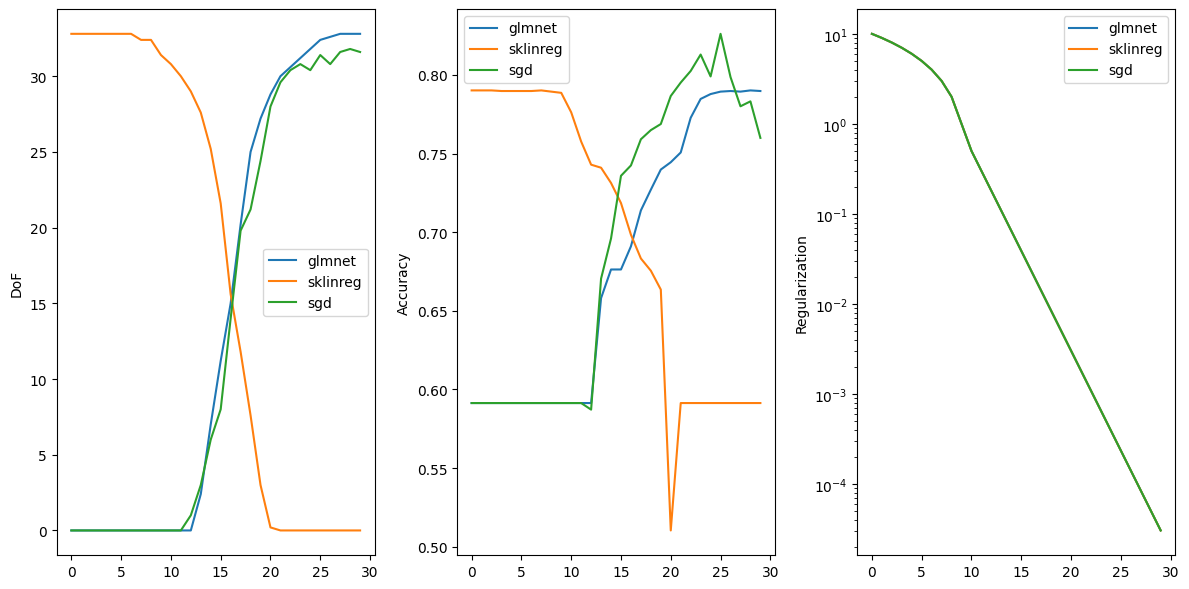

In [566]:
fig = plt.figure(figsize=(12,6))

steps = list(range(len(reg_params)))
legend = ["glmnet", "sklinreg", "sgd"]

p0 = fig.add_subplot(131)
p0.plot(steps, glmnet_cv_res[("mean", "dof")], label=legend[0])
p0.plot(steps, sk_linreg_res[("mean", "dof")], label=legend[1])
p0.plot(steps, sgd_cv_res[("mean", "dof")], label=legend[2])
p0.set_ylabel("DoF")
p0.legend()

p1 = fig.add_subplot(132)
p1.plot(steps, glmnet_cv_res[("mean", "accuracy")], label=legend[0])
p1.plot(steps, sk_linreg_res[("mean", "accuracy")], label=legend[1])
p1.plot(steps, sgd_cv_res[("mean", "accuracy")], label=legend[2])
p1.set_ylabel("Accuracy")
p1.legend()

p2 = fig.add_subplot(133)
p2.plot(steps, glmnet_reg_params, label=legend[0])
p2.plot(steps, sk_reg_params, label=legend[1])
p2.plot(steps, sgd_reg_params, label=legend[2])
p2.set_yscale("log")
p2.set_ylabel("Regularization")
p2.legend()

fig.tight_layout()